In [1]:
base_dir = 'C:\\Projects\\ature'
import os
os.chdir(base_dir) #BASE DIRECTORY

### DRIVE dataset
data_file_path = 'data\\DRIVE\\test\\images'
mask_path = 'data\\DRIVE\\test\\mask'
ground_truth_path = 'data\\DRIVE\\test\\1st_manual'
mask_suffix =  '_test_mask.gif'
ground_truth_suffix = '_manual1.gif'

input_image = '19_test.tif'

In [7]:
#!/home/akhanal1/Spring2018/pl-env/bin/python3.5
import sys
import numpy as np
import itertools as itr
from random import shuffle
from commons.segmentation import AtureTest
from PIL import Image as IMG
from commons.IMAGE import SegmentedImage
import cv2
import preprocess.utils.filter_utils as filutils
import copy


SK_THRESHOLD_PARAMS = np.arange(40, 61, 20)
ALPHA_PARAMS = np.arange(5, 7, 0.5)
GABOR_CONTRIBUTION_PARAMS = np.arange(0.6, 1.1, 0.2)
SEGMENTATION_THRESHOLD_PARAMS = np.arange(9, 15, 0.5)

PARAMS_ITR = itr.product(SK_THRESHOLD_PARAMS, ALPHA_PARAMS, GABOR_CONTRIBUTION_PARAMS, SEGMENTATION_THRESHOLD_PARAMS)

PARAMS_COMBINATION = list(PARAMS_ITR)
shuffle(PARAMS_COMBINATION)

keys = ('sk_threshold', 'alpha', 'gabor_contrib', 'seg_threshold')

all_params = list(dict(zip(keys, param)) for param in PARAMS_COMBINATION)

params = {'sk_threshold': 80,
          'alpha': 6.0,
          'orig_contrib': 0.2,
          'seg_threshold': 13}

In [8]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
def get_mask_file(file_name): return file_name.split('_')[0] + mask_suffix
def get_ground_truth_file(file_name): return file_name.split('_')[0] + ground_truth_suffix

img_obj = SegmentedImage()

img_obj.load_file(data_dir=data_file_path, file_name=input_image)
img_obj.load_mask(mask_dir=mask_path, fget_mask=get_mask_file, erode=True)
img_obj.load_ground_truth(gt_dir=ground_truth_path, fget_ground_truth=get_ground_truth_file)

img_obj.res['orig'] = img_obj.image_arr[:, :, 1]
img_obj.working_arr = img_obj.image_arr[:, :, 1]

img_obj.apply_mask()
img_obj.apply_bilateral()
img_obj.apply_gabor()

img_obj.generate_lattice_graph()

Mask loaded: 19_test_mask.gif
Ground truth loaded: 19_manual1.gif
"apply_bilateral(__)" ... took 0.094 seconds
"apply_gabor(__)" ... took 1.097 seconds
"generate_lattice_graph(__)" ... took 2.1 seconds


In [ ]:
### Run for image files with in-time mask erosion
tester = AtureTest(out_dir='out')
acc = tester.run(params=params, save_images=False, img_obj=img_obj)
# tester.run_all(params_combination=all_params)

"generate_skeleton(__)" ... took 0.0 seconds
"run_segmentation(__)" ...

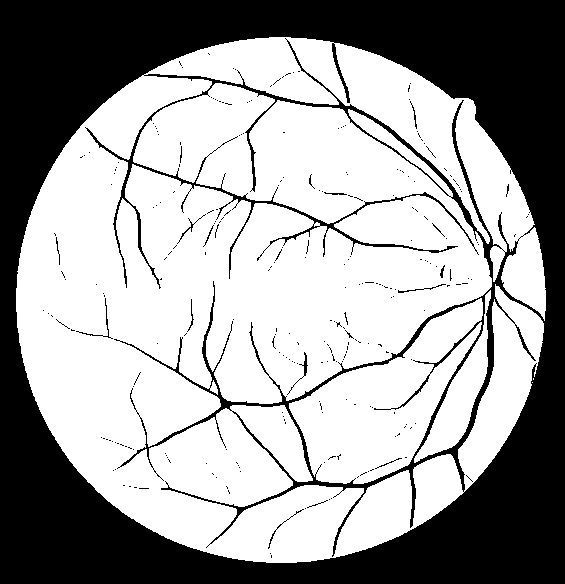

In [11]:
IMG.fromarray(img_obj.res['skeleton'])

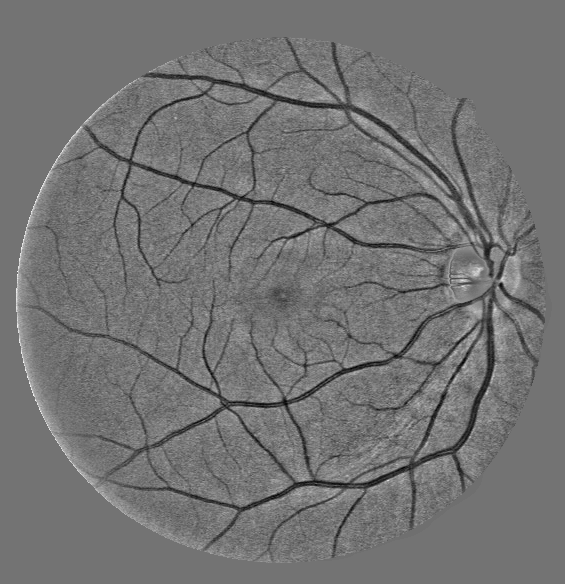

In [16]:
IMG.fromarray(img_obj.res['diff_bilateral'])

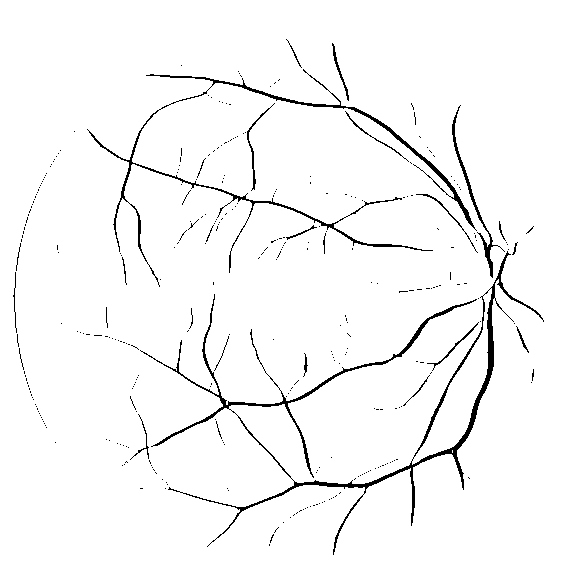

In [34]:
IMG.fromarray(img_obj.res['skeleton'])

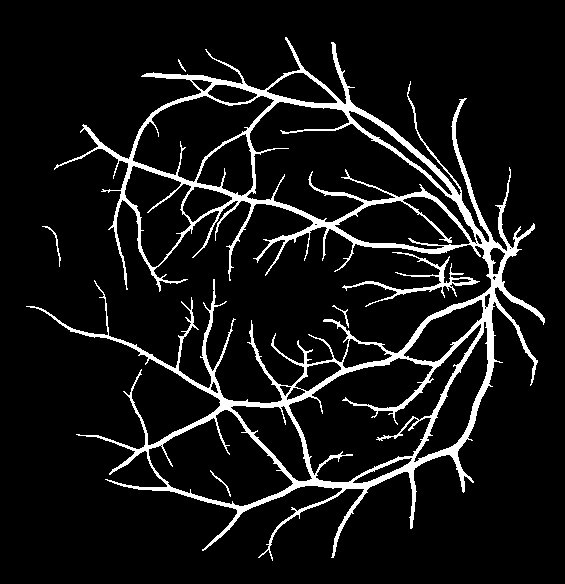

In [35]:
IMG.fromarray(img_obj.res['segmented'])

In [36]:
print(img_obj.res['scores'])

{'Precision': 0.8275788195808191, 'Recall': 0.846808666106463, 'Accuracy': 0.9726572917929446, 'F1': 0.8370833182852396}


In [25]:
print(img_obj.res['params'])

{'sk_threshold': 80, 'alpha': 6.0, 'orig_contrib': 0, 'seg_threshold': 14}


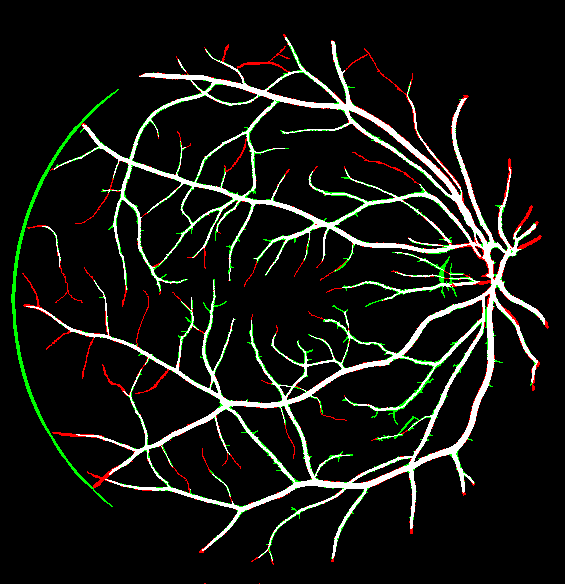

In [37]:
IMG.fromarray(img_obj.res['segmented_rgb'])

In [266]:
fni = np.full(acc.arr_2d.shape, 250, dtype=np.uint8)
for i in range(fni.shape[0]):
    for j in range(fni.shape[1]):
        if acc.arr_2d[i,j] == 0 and acc.img_obj.ground_truth[i,j] == 255:
            fni[i, j] = acc.img_obj.img_gabor[i,j]

In [396]:
m = img_obj1.img_gabor.copy()
for n1, n2 in acc.res['graph0'].edges():
    m[n1] = 255
    m[n2] = 255